# Model v2
### Leaderboard: 0.36987

In [114]:
from keras.layers import Input, LSTM, Dense, Dropout, Embedding, TimeDistributed, Reshape, Flatten
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout, GaussianNoise

In [2]:
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate

In [3]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [4]:
import tensorflow as tf
from keras import backend as K

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [6]:
from sklearn_pandas import DataFrameMapper

In [7]:
import pandas as pd
import numpy as np

In [8]:
from keras.utils.np_utils import to_categorical

In [115]:
version = 2
version_str = "v" + str(version)

In [10]:
LABEL = "price_doc"

In [11]:
def prepare_dataset(df, test=False, trunc_fields=False):
    global LABEL
    t_fields = ['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor','material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', LABEL]
    
    if not test:
        if trunc_fields:
            df = df[t_fields.append + LABEL]
        else:
            df = df
    else:
        if trunc_fields:
            df = df[t_fields]
        else:
            df = df
    
    df['timestamp_converted'] = pd.to_datetime(df['timestamp'])
    df['timestamp_day'] = df.apply(lambda row: row['timestamp_converted'].day, axis=1)
    df['timestamp_month'] = df.apply(lambda row: row['timestamp_converted'].month, axis=1)
    df['timestamp_year'] = df.apply(lambda row: row['timestamp_converted'].year, axis=1)
    df['state_refractored'] = df.apply( lambda row: 5 if row['state'] == 33 else row['state'] , axis = 1)
    
    df = df.fillna(0)
    
    df['state_refractored'] = df['state_refractored'].astype(int)    
    df['material'] = df['material'].astype(int)    
    return df

In [12]:
final_train_df = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/final_training_dataset.csv")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (375,378,379) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
final_train_df = prepare_dataset(final_train_df)

In [14]:
del final_train_df['Unnamed: 0']

In [15]:
final_train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,1,2011-08-20,43,27.0,4.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2,2011-08-23,34,19.0,3.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,3,2011-08-27,43,29.0,2.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,4,2011-09-01,89,50.0,9.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,5,2011-09-05,77,77.0,4.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


## Data prep

In [16]:
def dedup(listy):
    return list(set(listy))

In [116]:
property_columns = [
    # Place features
 'full_sq',
 'kitch_sq',
 'floor',
 'life_sq',
 'build_year',
 'num_room',
 'max_floor',
 'sub_area',
]

time_columns = [
 'timestamp_day',
 'timestamp_month',
 'timestamp_year',
]

population_columns = [
    # Economy: Population
    'male_f',
    'female_f',
    'young_all',
    'young_male',
    'young_female',
    'work_all',
    'work_male',
    'work_female',
    'ekder_all',
    'ekder_male',
    'ekder_female',
    
    'marriages_per_1000_cap',
    'divorce_rate',
    'pop_natural_increase',
    'pop_migration',
    'pop_total_inc',
    'childbirth',
    'mortality',
    'average_life_exp',
]

locality_columns = [
 'metro_min_avto',
    
 'railroad_station_avto_min',
    
 'green_part_1000',
 'green_part_1500',
    
     # Raion = number of...
  'big_market_raion',
  'nuclear_reactor_raion',
  'detention_facility_raion',
  'full_all',
  'shopping_centers_raion',
  'office_raion',
  'thermal_power_plant_raion',
  'healthcare_centers_raion',
  'university_top_20_raion',
    
  # Locality features...
 'railroad_km',
 'green_zone_km',
 'kindergarten_km',
 'public_transport_station_km',
 'metro_km_avto',
 'park_km',
 'cemetery_km',
 'mosque_km',
 'public_healthcare_km',
 'catering_km',
 'big_road2_km',
 'hospice_morgue_km',
 'swim_pool_km',
 'water_treatment_km',
 'power_transmission_line_km',
 'water_km',
 'school_km',
 'ttk_km',
 'area_m',
 'ts_km',
 'university_km',
 'oil_chemistry_km',
 'exhibition_km',
 'shopping_centers_km',
 'zd_vokzaly_avto_km',
 'preschool_km',
 'big_road1_km',
 'additional_education_km',
 'church_synagogue_km',
 'big_church_km',
 'incineration_km',
 'industrial_km',
 'nuclear_reactor_km',
]

economy_columns = [
    
    
     'usdrub',
 'micex_cbi_tr',
 'brent', 
    
     'micex',
    
    'oil_urals',
     
 # Economy features
 'gdp_quart',
 'gdp_quart_growth',
 'cpi',
    'ppi',
    'gdp_deflator',
    'gdp_annual',
    'gdp_annual_growth',
    'average_provision_of_build_contract',
    'average_provision_of_build_contract_moscow',
    'rts',
    'deposits_value',
    'deposits_growth',
    'deposits_rate',
    'mortgage_value',
    'mortgage_growth',
    'mortgage_rate',
    'grp',
    'grp_growth',
    'income_per_cap',
    'real_dispos_income_per_cap_growth',
    'salary',
    'salary_growth',
    'labor_force',
    'unemployment',
    'employment',
    'construction_value',
    'housing_fund_sqm',
    'lodging_sqm_per_cap',
    'water_pipes_share',
    'baths_share',
    'sewerage_share',
    'gas_share',
    'hot_water_share',
    'electric_stove_share',
    'heating_share',
    'old_house_share',
    'incidence_population',
    'rent_price_4+room_bus',
    'rent_price_3room_bus',
    'rent_price_2room_bus',
    'rent_price_1room_bus',
    'rent_price_3room_eco',
    'rent_price_2room_eco',
    'rent_price_1room_eco',
    'apartment_build',
    'apartment_fund_sqm',
    'indust_part',
]

one_hot_cols = [
    'material',
    'state_refractored'
]

columns = dedup(property_columns + population_columns + economy_columns + locality_columns + time_columns + one_hot_cols)

label_cols = [
    'sub_area',
    'big_market_raion',
    'nuclear_reactor_raion',
    'thermal_power_plant_raion',
    'detention_facility_raion',
    'big_market_raion',
  'nuclear_reactor_raion',
  'detention_facility_raion',
  'full_all',
  'shopping_centers_raion',
  'office_raion',
  'thermal_power_plant_raion',
  'healthcare_centers_raion',
  'university_top_20_raion',
]

exclude_normalize_columns = [
    # Specific columns to exclude...
] + one_hot_cols + label_cols


embedding_columns = [
    'sub_area'
]

normalize_columns = [c for c in columns if c not in exclude_normalize_columns]

#locality_columns = [c for c in columns if "_km" in c]
continuous_columns = [c for c in columns if c not in one_hot_cols and c not in label_cols]
continuous_columns_without_locality = [c for c in continuous_columns if c not in locality_columns]

In [117]:
final_train_df = final_train_df[columns + [LABEL, 'timestamp_converted']]

In [118]:
final_train_df.head()

,micex_cbi_tr,unemployment,apartment_build,railroad_station_avto_min,rts,pop_migration,work_all,state_refractored,healthcare_centers_raion,max_floor,...,salary,cpi,rent_price_4+room_bus,micex,rent_price_3room_bus,average_provision_of_build_contract_moscow,average_life_exp,marriages_per_1000_cap,price_doc,timestamp_converted
0,204.78,0.014,23587.0,6.905893,1575.33,5.1,98207,0,1,0.0,...,44898.7,354.0,136.11,1438.74,77.93,6.74,75.79,8.5,5850000,2011-08-20
1,204.92,0.014,23587.0,4.679745,1578.91,5.1,70194,0,1,0.0,...,44898.7,354.0,136.11,1444.11,77.93,6.74,75.79,8.5,6000000,2011-08-23
2,204.84,0.014,23587.0,1.701420,1596.17,5.1,63388,0,1,0.0,...,44898.7,354.0,136.11,1458.84,77.93,6.74,75.79,8.5,5700000,2011-08-27
3,205.42,0.014,23587.0,5.271136,1703.86,5.1,120381,0,1,0.0,...,44898.7,353.2,155.22,1551.58,94.02,6.74,75.79,8.5,13100000,2011-09-01
4,198.24,0.014,23587.0,2.156284,1617.01,5.1,68043,0,4,0.0,...,44898.7,353.2,155.22,1492.83,94.02,6.74,75.79,8.5,16331452,2011-09-05


In [119]:
final_train_df = final_train_df.convert_objects(convert_numeric=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


## Prepare numeric data scalers & normalizers

In [120]:
norm_scalers = {column : preprocessing.StandardScaler() for column in normalize_columns}

In [121]:
norm_scalers

{'additional_education_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'apartment_build': StandardScaler(copy=True, with_mean=True, with_std=True),
 'apartment_fund_sqm': StandardScaler(copy=True, with_mean=True, with_std=True),
 'area_m': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_life_exp': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_provision_of_build_contract': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_provision_of_build_contract_moscow': StandardScaler(copy=True, with_mean=True, with_std=True),
 'baths_share': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_church_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_road1_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_road2_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'brent': StandardScaler(copy=True, with_mean=True, with_std=True),
 'build_year': StandardScaler(copy=T

In [122]:
len(norm_scalers)

118

In [123]:
ont_hot_scalers = {column : (preprocessing.LabelEncoder(), preprocessing.OneHotEncoder(sparse=False)) for column in one_hot_cols}

In [124]:
ont_hot_scalers

{'material': (LabelEncoder(),
  OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
         handle_unknown='error', n_values='auto', sparse=False)),
 'state_refractored': (LabelEncoder(),
  OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
         handle_unknown='error', n_values='auto', sparse=False))}

In [125]:
label_scalers = {column : preprocessing.LabelEncoder() for column in label_cols}

In [126]:
label_scalers

{'big_market_raion': LabelEncoder(),
 'detention_facility_raion': LabelEncoder(),
 'full_all': LabelEncoder(),
 'healthcare_centers_raion': LabelEncoder(),
 'nuclear_reactor_raion': LabelEncoder(),
 'office_raion': LabelEncoder(),
 'shopping_centers_raion': LabelEncoder(),
 'sub_area': LabelEncoder(),
 'thermal_power_plant_raion': LabelEncoder(),
 'university_top_20_raion': LabelEncoder()}

In [127]:
for column in normalize_columns:
    c_scaler = norm_scalers[column]
    try:
        c_scaler.fit(final_train_df[[column]].values)
    except:
        print 'failed: ', column

In [128]:
for column in one_hot_cols:
    label_enc, one_hot_enc = ont_hot_scalers[column]
    r = label_enc.fit_transform(final_train_df[[column]].values)
    r = np.expand_dims(r, axis=1)
    one_hot_enc.fit(r)

In [129]:
for column in label_cols:
    label_enc = label_scalers[column]
    label_enc.fit(final_train_df[[column]].values)

### Test the scalers...

In [130]:
norm_scalers['timestamp_day'].transform([final_train_df.ix[0]['timestamp_day']])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.40933319])

In [131]:
ont_hot_scalers['material'][1].transform([final_train_df.ix[70]['material']])

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [132]:
label_scalers['sub_area'].transform([final_train_df.ix[0]['sub_area']])

array([9])

In [133]:
sub_area_metadata = open('/mnt/h/Kaggle/Competitions/Russian Bank/models/metadata/sub_area_metadata.tsv', 'w+')
sub_area_metadata.write("Sub area\n" + "\n".join([label_scalers['sub_area'].inverse_transform([i])[0] for i in range(146)]))
sub_area_metadata.close()

### Save them to disk

In [134]:
from sklearn.externals import joblib

In [135]:
joblib.dump(norm_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/norm_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/norm_scalers.pkl']

In [136]:
joblib.dump(ont_hot_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/one_hot_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/one_hot_scalers.pkl']

In [137]:
joblib.dump(label_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/label_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/label_scalers.pkl']

### Transform the whole training data

In [138]:
for continuous_norm_col in normalize_columns:
    scaler = norm_scalers[continuous_norm_col]
    scaled_values = scaler.transform(final_train_df[[continuous_norm_col]].values)
    final_train_df[continuous_norm_col + "_scaled_feature"] = scaled_values

In [139]:
for one_hot_col in one_hot_cols:
    l_scaler = ont_hot_scalers[one_hot_col][0]
    scaler = ont_hot_scalers[one_hot_col][1]
    r = l_scaler.transform(final_train_df[[one_hot_col]].values)
    r = np.expand_dims(r, axis=1)
    scaled_values = scaler.transform(r)
    final_train_df[one_hot_col + "_scaled_feature"] = list(scaled_values)

In [140]:
for label_col in label_cols:
    label_enc = label_scalers[label_col]
    encoded_values = label_enc.transform(final_train_df[[label_col]].values)
    final_train_df[label_col + "_scaled_feature"] = encoded_values

In [141]:
def extract_normalized_feature(df, feature_name):
    return np.array(df[feature_name + "_scaled_feature"].values.tolist())

In [142]:
extract_normalized_feature(final_train_df, "full_sq")

array([-0.29487286, -0.53152276, -0.29487286, ..., -0.24228399,
        0.25731024, -0.29487286])

In [143]:
extract_normalized_feature(final_train_df, "life_sq")

array([-0.00404841, -0.16882931,  0.03714682, ..., -0.56018395,
        0.09893965,  0.0165492 ])

In [144]:
extract_normalized_feature(final_train_df, "sub_area")

array([  9,  70, 129, ..., 103,  77,  75])

In [145]:
locality_columns[0], extract_normalized_feature(final_train_df, locality_columns[0])

('metro_min_avto',
 array([-0.36180133, -0.61411914, -0.43340412, ..., -0.42855279,
        -0.24162376, -0.66784139]))

In [146]:
extract_normalized_feature(final_train_df, "sub_area")

array([  9,  70, 129, ..., 103,  77,  75])

In [147]:
def extract_temporal_features(df):
    global time_columns
    vals = []
    for c in time_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [148]:
def extract_property_place_features(df):
    global property_columns
    vals = []
    for c in property_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [149]:
def extract_economy_features(df):
    global economy_columns
    vals = []
    for c in economy_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [150]:
def extract_population_features(df):
    global population_columns
    vals = []
    for c in population_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [151]:
def extract_locality_features(df):
    global locality_columns
    vals = []
    for c in locality_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [152]:
def extract_categorical_features(df):
    global one_hot_cols, label_cols
    vals = {}
    for c in one_hot_cols + label_cols:
        vals[c]  = extract_normalized_feature(df, c)
    return vals

In [153]:
#extract_continuous_features(final_train_df).shape # 51 + 3 (one hot columns) + 1 (label) = 55 (total dataframe columns excluding id)...

In [154]:
extract_locality_features(final_train_df).shape

(30471, 46)

In [155]:
extract_categorical_features(final_train_df)

{'big_market_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'detention_facility_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'full_all': array([78, 59, 89, ..., 18, 73, 54]),
 'healthcare_centers_raion': array([1, 1, 1, ..., 0, 2, 2]),
 'material': array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]]),
 'nuclear_reactor_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'office_raion': array([1, 0, 1, ..., 0, 5, 1]),
 'shopping_centers_raion': array([13,  3,  0, ...,  1,  4,  5]),
 'state_refractored': array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.]]),
 'sub_area': array([  9,  7

### Generate LSTM timestep input data

In [156]:
timesteps = 3

In [157]:
final_train_df['timestamp_converted'] = pd.to_datetime(final_train_df['timestamp_converted'])

In [158]:
final_train_df.sort('timestamp_converted')[['timestamp_converted', 'price_doc']]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,timestamp_converted,price_doc
0,2011-08-20,5850000
1,2011-08-23,6000000
2,2011-08-27,5700000
3,2011-09-01,13100000
4,2011-09-05,16331452
5,2011-09-06,9100000
6,2011-09-08,5500000
7,2011-09-09,2000000
8,2011-09-10,5300000
9,2011-09-13,2000000


In [159]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2):
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

In [222]:
train_split_df, test_split_df = train_test_split(final_train_df, test_size = 0.1)

In [223]:
train_split_df_temporal_features = extract_temporal_features(train_split_df)
test_split_df_temporal_features = extract_temporal_features(test_split_df)

In [224]:
train_split_df_property_features = extract_property_place_features(train_split_df)
test_split_df_property_features = extract_property_place_features(test_split_df)

In [225]:
train_split_df_locality_features = extract_locality_features(train_split_df)
test_split_df_locality_features = extract_locality_features(test_split_df)

In [226]:
train_split_df_economy_features = extract_economy_features(train_split_df)
test_split_df_economy_features = extract_economy_features(test_split_df)

In [227]:
train_split_df_population_features = extract_population_features(train_split_df)
test_split_df_population_features = extract_population_features(test_split_df)

In [228]:
train_split_df_categorical_features = extract_categorical_features(train_split_df)
test_split_df_categorical_features = extract_categorical_features(test_split_df)

In [229]:
def format_input(df):
    temporal_features = extract_temporal_features(df)
    property_features = extract_property_place_features(df)
    locality_features = extract_locality_features(df)
    economy_features = extract_economy_features(df)
    population_features = extract_population_features(df)
    categorical_features = extract_categorical_features(df)
    return temporal_features, property_features, locality_features, economy_features, population_features, categorical_features

In [230]:
train_split_df_temporal_features.shape, train_split_df_property_features.shape, train_split_df_locality_features.shape, train_split_df_economy_features.shape,  train_split_df_population_features.shape

((27423, 3), (27423, 8), (27423, 46), (27423, 52), (27423, 19))

In [231]:
def combine_inputs(features, axis=1):
    fts = []
    for f in features:
        if len(f.shape) == 1:
            fts.append(np.expand_dims(f, axis=1))
        else:
            fts.append(f)
    return np.concatenate(tuple(fts), axis=axis)

In [232]:
train_split_df_combined_inputs = combine_inputs([train_split_df_temporal_features, train_split_df_property_features, train_split_df_locality_features, train_split_df_economy_features, train_split_df_population_features] + [v for k,v in train_split_df_categorical_features.items() if k not in embedding_columns])

In [233]:
test_split_df_combined_inputs = combine_inputs([test_split_df_temporal_features, test_split_df_property_features, test_split_df_locality_features, test_split_df_economy_features, test_split_df_population_features] + [v for k,v in test_split_df_categorical_features.items() if k not in embedding_columns])

In [234]:
train_split_df_combined_inputs.shape, test_split_df_combined_inputs.shape

((27423, 150), (3048, 150))

In [235]:
num_main_features = train_split_df_combined_inputs.shape[1]
num_main_features

150

## Model

In [236]:
"""
The main model, version: 2
""" 
def main_model_v2(num_continuous_features, output_activation='relu'):
    
    with tf.name_scope("house_price_model"):
        
        # Inputs
        with tf.name_scope("inputs"):
            ## Continuous
            main_input = Input(shape=(num_continuous_features,), name="main_input")
            
            ## Categorical (labelled)
            sub_area_input = Input(shape=(1,), dtype='int32', name='sub_area_input')
            sub_area_vocab_size = 200 # It's actually 146, but rounding it to 200
            sub_area_embedding_dim = 8
            
        with tf.name_scope("sub_area_embedding"):
            # Network
            ## Embedding
            sub_area_vector = Embedding(output_dim=sub_area_embedding_dim, input_dim=sub_area_vocab_size, input_length=1, name="sub_area_embedding")(sub_area_input)
            sub_area_vector = Flatten()(sub_area_vector)
            
        with tf.name_scope("fully_connected"):
            ## Concatenate all suboutput vectors into one big vector
            merged_output_vector = Concatenate()([main_input, sub_area_vector])
            merged_output_vector = GaussianNoise(0.01)(merged_output_vector)      
        
            ## Some final hidden layers
            #merged_output_vector = GaussianDropout(0.4)(merged_output_vector)
            merged_output_vector = Dense(512, activation='relu')(merged_output_vector)
            merged_output_vector = Dropout(0.4)(merged_output_vector) # Batch normalize this combined pre-output vector
            #merged_output_vector = Dropout(0.4)(merged_output_vector)
            merged_output_vector = Dense(256, activation='relu')(merged_output_vector)
            merged_output_vector = Dropout(0.2)(merged_output_vector) # Batch normalize this combined pre-output vector
            #merged_output_vector = Dropout(0.4)(merged_output_vector)
            merged_output_vector = Dense(128, activation='relu')(merged_output_vector)
            merged_output_vector = Dropout(0.1)(merged_output_vector) # Batch normalize this combined pre-output vector
    
            main_output = Dense(1, activation=output_activation, name="main_output")(merged_output_vector)
        
        return [main_input, sub_area_input], main_output

In [237]:
inputs, outputs = main_model_v2(num_main_features)

real_estate_price_model = Model(inputs=inputs, outputs=outputs)

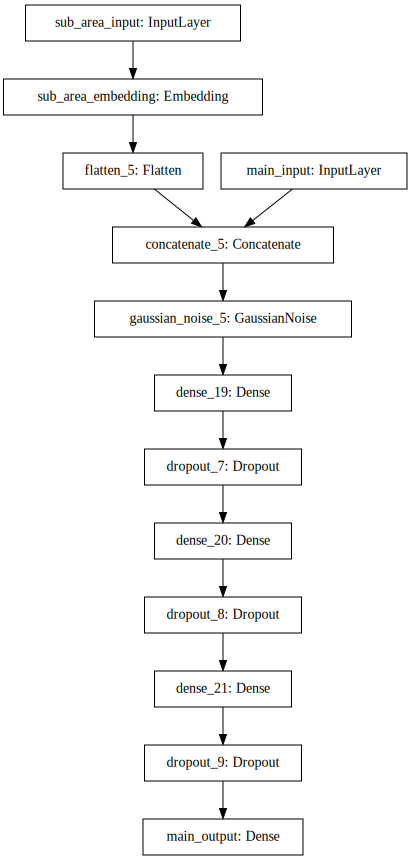

In [238]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

# Show the model in ipython notebook
SVG(model_to_dot(real_estate_price_model).create(prog='dot', format='svg'))

In [239]:
# Save the model as png file
from keras.utils.vis_utils import plot_model
plot_model(real_estate_price_model, to_file='/mnt/h/Kaggle/Competitions/Russian Bank/models/'+version_str+'/model.png', show_shapes=True)

In [240]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
    y_pred_log = K.log(y_pred + 1.)
    y_true_log = K.log(y_true + 1.)
    return K.sqrt(K.mean(K.square(y_pred_log - y_true_log), axis = -1))

In [241]:
real_estate_price_model.compile(optimizer = "adam", 
                          loss = root_mean_squared_logarithmic_error
                         )

### Train the model

In [242]:
epochs = 100

In [243]:
checkpointer = ModelCheckpoint(filepath="/mnt/h/Kaggle/Competitions/Russian Bank/models/" + version_str + "/" + "weights.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="/mnt/h/Kaggle/Competitions/Russian Bank/models/" + version_str + "/logs/",
                          histogram_freq=0, 
                          write_graph=True, 
                         # write_grads=True, 
                          write_images=False, 
                          embeddings_freq=5, 
                          embeddings_layer_names=[
                              'sub_area_embedding'
                          ], embeddings_metadata={
                              'sub_area_embedding':'/mnt/h/Kaggle/Competitions/Russian Bank/models/metadata/sub_area_metadata.tsv'
                          })
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
callbacks = [checkpointer, tensorboard, early_stopping]

In [244]:
real_estate_price_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sub_area_input (InputLayer)      (None, 1)             0                                            
____________________________________________________________________________________________________
sub_area_embedding (Embedding)   (None, 1, 8)          1600        sub_area_input[0][0]             
____________________________________________________________________________________________________
main_input (InputLayer)          (None, 150)           0                                            
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 8)             0           sub_area_embedding[0][0]         
___________________________________________________________________________________________

In [245]:
real_estate_price_model.fit(x={
    'main_input' : train_split_df_combined_inputs,
    'sub_area_input' : train_split_df_categorical_features['sub_area']},
                      y = train_split_df['price_doc'].values,
                      callbacks=callbacks,
                      verbose = 2,
                      validation_split=0.25,
                      shuffle=True,
                      epochs=epochs)

Train on 20567 samples, validate on 6856 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.49642, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v2/weights.00-0.50.hdf5
32s - loss: 2.3247 - val_loss: 0.4964
Epoch 2/100
Epoch 00001: val_loss improved from 0.49642 to 0.44536, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v2/weights.01-0.45.hdf5
15s - loss: 0.4667 - val_loss: 0.4454
Epoch 3/100
Epoch 00002: val_loss improved from 0.44536 to 0.40340, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v2/weights.02-0.40.hdf5
17s - loss: 0.4166 - val_loss: 0.4034
Epoch 4/100
Epoch 00003: val_loss improved from 0.40340 to 0.37446, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v2/weights.03-0.37.hdf5
15s - loss: 0.3821 - val_loss: 0.3745
Epoch 5/100
Epoch 00004: val_loss improved from 0.37446 to 0.34681, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v2/weights.04-0.35.hdf5
16s - loss: 0.3550 - val_los

In [246]:
real_estate_price_model.load_weights('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/weights.18-0.25.hdf5')

In [247]:
train_loss = real_estate_price_model.evaluate(x={
    'main_input' : train_split_df_combined_inputs,
    'sub_area_input' : train_split_df_categorical_features['sub_area']},
                      y = train_split_df['price_doc'].values,
                      verbose = 2)
'Train loss: ', train_loss

('Train loss: ', 0.24662114753550304)

In [248]:
test_loss = real_estate_price_model.evaluate(x={
   'main_input' : test_split_df_combined_inputs,
    'sub_area_input' : test_split_df_categorical_features['sub_area']},
                      y = test_split_df['price_doc'].values,
                      verbose = 2)
'Test loss: ', test_loss

('Test loss: ', 0.23727549639899587)

In [249]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [250]:
seed = 7
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [251]:
kfold.get_n_splits(final_train_df, final_train_df[[LABEL]].values)

10

In [252]:
eval_loss_scores = []

for idx, (train, test) in enumerate(kfold.split(final_train_df, final_train_df[[LABEL]].values.ravel())):
    
    temp_x, temp_y = final_train_df.ix[train, :], final_train_df.ix[train, :][LABEL].values
    temp_test_x, temp_test_y = final_train_df.ix[test, :], final_train_df.ix[test, :][LABEL].values
    
    temp_train_split_df_temporal_features = extract_temporal_features(temp_x)
    temp_test_split_df_temporal_features = extract_temporal_features(temp_test_x)
    
    temp_train_split_df_property_features = extract_property_place_features(temp_x)
    temp_test_split_df_property_features = extract_property_place_features(temp_test_x)
    
    temp_train_split_df_locality_features = extract_locality_features(temp_x)
    temp_test_split_df_locality_features = extract_locality_features(temp_test_x)
    
    temp_train_split_df_economy_features = extract_economy_features(temp_x)
    temp_test_split_df_economy_features = extract_economy_features(temp_test_x)
    
    temp_train_split_df_population_features = extract_population_features(temp_x)
    temp_test_split_df_population_features = extract_population_features(temp_test_x)
    
    temp_train_split_df_categorical_features = extract_categorical_features(temp_x)
    temp_test_split_df_categorical_features = extract_categorical_features(temp_test_x)
    
    temp_train_split_df_combined_inputs = combine_inputs([temp_train_split_df_temporal_features, 
                                                     temp_train_split_df_property_features, 
                                                     temp_train_split_df_locality_features, 
                                                     temp_train_split_df_economy_features,
                                                    temp_train_split_df_population_features] + 
                                                    [v for k,v in temp_train_split_df_categorical_features.items() if k not in embedding_columns])
    temp_test_split_df_combined_inputs = combine_inputs([temp_test_split_df_temporal_features, 
                                                     temp_test_split_df_property_features, 
                                                     temp_test_split_df_locality_features, 
                                                     temp_test_split_df_economy_features,
                                                    temp_test_split_df_population_features] + 
                                                    [v for k,v in temp_test_split_df_categorical_features.items() if k not in embedding_columns])
    
    print 'Cross validating.... step: ', idx
    
    temp_train_loss = real_estate_price_model.evaluate(x={
        'main_input' : temp_train_split_df_combined_inputs,
        'sub_area_input' : temp_train_split_df_categorical_features['sub_area']},
                      y = temp_y,
                      verbose = 2)
    print 'Temp train loss: ', temp_train_loss, ' index: ', idx
    eval_loss_scores.append(temp_train_loss)
    
    temp_test_loss = real_estate_price_model.evaluate(x={
        'main_input' : temp_test_split_df_combined_inputs,
        'sub_area_input' : temp_test_split_df_categorical_features['sub_area']},
                      y = temp_test_y,
                      verbose = 2)
    print 'Temp test loss: ', temp_test_loss, ' index: ', idx
    eval_loss_scores.append(temp_test_loss)
    
    
print eval_loss_scores


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Cross validating.... step:  0
Temp train loss:  0.246602402664  index:  0
Temp test loss:  0.237900917667  index:  0
Cross validating.... step:  1
Temp train loss:  0.24563480725  index:  1
Temp test loss:  0.24613140233  index:  1
Cross validating.... step:  2
Temp train loss:  0.245356192985  index:  2
Temp test loss:  0.248577097021  index:  2
Cross validating.... step:  3
Temp train loss:  0.245613432265  index:  3
Temp test loss:  0.246334391987  index:  3
Cross validating.... step:  4
Temp train loss:  0.245590202969  index:  4
Temp test loss:  0.246558900655  index:  4
Cross validating.... step:  5
Temp train loss:  0.246109629462  index:  5
Temp test loss:  0.241867908244  index:  5
Cross validating.... step:  6
Temp train loss:  0.245505946937  index:  6
Temp test loss:  0.247358237658  index:  6
Cross validating.... step:  7
Temp train loss:  0.245466008387  index:  7
Temp test loss:  0.247696141151  index:  7
Cross validating.... step:  8
Temp train loss:  0.245724684932  in

In [253]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(eval_loss_scores), np.std(eval_loss_scores)))

0.25% (+/- 0.00%)


In [273]:
real_estate_price_model.save('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/trained_model_0.25_val_loss.h5')

In [117]:
from keras.models import load_model

In [118]:
real_estate_price_model_duplicate = load_model('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/trained_model_0.22_val_loss.h5', custom_objects={"root_mean_squared_logarithmic_error":root_mean_squared_logarithmic_error})

In [255]:
test_temporal_features, test_property_features, test_locality_features, test_economy_features, test_population_features, test_categorical_features = format_input(test_split_df[:10])
test_t_combined_inputs = combine_inputs([test_temporal_features, 
                                                     test_property_features, 
                                                     test_locality_features, 
                                                     test_economy_features,
                                                    test_population_features] + 
                                                    [v for k,v in test_categorical_features.items() if k not in embedding_columns])
test_preds = real_estate_price_model.predict(x={
    'main_input' : test_t_combined_inputs,
    'sub_area_input' : test_categorical_features['sub_area']})
test_actuals = test_split_df[:10].price_doc.values

In [256]:
zip(test_actuals, test_preds.ravel())

[(3423615, 3223575.0),
 (7300000, 7537837.0),
 (990000, 5850316.0),
 (5467000, 5752084.0),
 (11600000, 11861280.0),
 (8215901, 9805575.0),
 (13500000, 12316355.0),
 (7505546, 6895373.0),
 (5300000, 5654896.0),
 (5550000, 5670680.0)]

In [257]:
kaggle_test = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/test.csv/test.csv")

In [258]:
kaggle_test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [259]:
macro_df = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/macro.csv/macro.csv")

In [260]:
final_kaggle_df = pd.merge(kaggle_test, macro_df, on='timestamp')

In [261]:
final_kaggle_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9


In [262]:
final_kaggle_df = prepare_dataset(final_kaggle_df)

In [263]:
for continuous_norm_col in normalize_columns:
    scaler = norm_scalers[continuous_norm_col]
    scaled_values = scaler.transform(final_kaggle_df[[continuous_norm_col]].values)
    final_kaggle_df[continuous_norm_col + "_scaled_feature"] = scaled_values

In [264]:
for one_hot_col in one_hot_cols:
    l_scaler = ont_hot_scalers[one_hot_col][0]
    scaler = ont_hot_scalers[one_hot_col][1]
    r = l_scaler.transform(final_kaggle_df[[one_hot_col]].values)
    r = np.expand_dims(r, axis=1)
    scaled_values = scaler.transform(r)
    final_kaggle_df[one_hot_col + "_scaled_feature"] = list(scaled_values)

In [265]:
for label_col in label_cols:
    label_enc = label_scalers[label_col]
    encoded_values = label_enc.transform(final_kaggle_df[[label_col]].values)
    final_kaggle_df[label_col + "_scaled_feature"] = encoded_values

In [266]:
[c for c in final_kaggle_df.columns.tolist() if "_scaled_feature" in c]

['micex_cbi_tr_scaled_feature',
 'unemployment_scaled_feature',
 'apartment_build_scaled_feature',
 'railroad_station_avto_min_scaled_feature',
 'rts_scaled_feature',
 'pop_migration_scaled_feature',
 'work_all_scaled_feature',
 'max_floor_scaled_feature',
 'housing_fund_sqm_scaled_feature',
 'heating_share_scaled_feature',
 'catering_km_scaled_feature',
 'zd_vokzaly_avto_km_scaled_feature',
 'mortality_scaled_feature',
 'water_km_scaled_feature',
 'green_part_1000_scaled_feature',
 'deposits_rate_scaled_feature',
 'park_km_scaled_feature',
 'big_road1_km_scaled_feature',
 'hospice_morgue_km_scaled_feature',
 'metro_km_avto_scaled_feature',
 'ekder_male_scaled_feature',
 'female_f_scaled_feature',
 'deposits_growth_scaled_feature',
 'usdrub_scaled_feature',
 'deposits_value_scaled_feature',
 'gdp_annual_growth_scaled_feature',
 'big_church_km_scaled_feature',
 'exhibition_km_scaled_feature',
 'area_m_scaled_feature',
 'young_male_scaled_feature',
 'ekder_all_scaled_feature',
 'divorce_

In [267]:
kaggle_temporal_features, kaggle_property_features, kaggle_locality_features, kaggle_economy_features, kaggle_population_features, kaggle_categorical_features = format_input(final_kaggle_df)
kaggle_combined_inputs = combine_inputs([kaggle_temporal_features, 
                                                     kaggle_property_features, 
                                                     kaggle_locality_features, 
                                                     kaggle_economy_features,
                                                    kaggle_population_features] + 
                                                    [v for k,v in kaggle_categorical_features.items() if k not in embedding_columns])
kaggle_preds = real_estate_price_model.predict(x={
    'main_input' : kaggle_combined_inputs,
    'sub_area_input' : kaggle_categorical_features['sub_area']})

In [268]:
final_kaggle_df['price_doc'] = kaggle_preds

In [269]:
final_kaggle_df['price_doc']

0        5880385.00
1        8747043.00
2        6298690.00
3        6858484.00
4        5549552.00
5        8727317.00
6        4832307.00
7        4594226.00
8        5736204.00
9        5148752.00
10       6578606.00
11       5241682.50
12       4955262.00
13       4775061.00
14       4861991.50
15       6553341.50
16      15251378.00
17      15826982.00
18       6276733.00
19      12756315.00
20       7439958.00
21      10608332.00
22       9471844.00
23       9561188.00
24       5613341.00
25      10385531.00
26      11192737.00
27       8029026.50
28       3457591.00
29       7588155.00
           ...     
7632     5395088.50
7633     3818764.50
7634     9053429.00
7635     5843685.00
7636     3000335.25
7637     4398782.00
7638     3272240.50
7639     6565595.00
7640     6662632.50
7641     3215262.25
7642     6269689.50
7643     6126363.00
7644     6988746.00
7645     3320255.25
7646     6477169.50
7647     6265315.00
7648     6612234.50
7649     5803001.50
7650     5714071.00


In [271]:
final_kaggle_df[['id', 'price_doc']]

,id,price_doc
0,30474,5880385.00
1,30475,8747043.00
2,30476,6298690.00
3,30477,6858484.00
4,30478,5549552.00
5,30479,8727317.00
6,30480,4832307.00
7,30481,4594226.00
8,30482,5736204.00
9,30483,5148752.00


In [272]:
final_kaggle_df[['id', 'price_doc']].to_csv("/mnt/h/Kaggle/Competitions/Russian Bank/models/v" + str(version) + "/submission.csv", index=False) # output submission csv file